In [ ]:
# pre processamento de dados
import pandas as pd
import numpy as np

# deep learning framework
import torch
from torch import nn, optim
import torch.nn.functional as F

# scalers e métricas
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# plotting e visualização
from torchsummary import summary
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### Carregando o dataset

In [ ]:
df = pd.read_csv('btc.csv', index_col='Date', parse_dates=True)
df.drop(columns=['Symbol'], inplace=True)
df.sort_values(by='Date', inplace=True)
df.head()

In [ ]:
plt.plot(df.Close)
plt.xlabel("Período")
plt.ylabel("Preço (USD)")
plt.title("Preço do bitcoin ao longo do tempo")
plt.show();

In [ ]:
# separando features e labels
X, y = df.drop(columns=['Close']), df.Close.values
X.shape, y.shape

In [ ]:
mm = MinMaxScaler()
ss = StandardScaler()

X_scaled = ss.fit_transform(X)
y_scaled = mm.fit_transform(y.reshape(-1, 1))

In [ ]:
# pega os n_steps_in input_sequences mais recentes para prever os próximos n_steps_out output_sequence
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(input_sequences)):
        # encontra o final das sequências de input e output
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        if out_end_ix > len(input_sequences): break
        # coleta input_sequence e output_sequence
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)

X_ss, y_mm = split_sequences(X_scaled, y_scaled, 100, 50)
print(X_ss.shape, y_mm.shape)

In [ ]:
X_ss[0]

In [ ]:
y_mm[0]

In [ ]:
y_scaled[99:149].squeeze(1)

In [ ]:
train_size = int(len(X_scaled)*0.8)
test_size = len(X_scaled) - train_size

train_size, test_size

In [ ]:
X_train = X_ss[:-(test_size)]
X_test = X_ss[-(test_size):]

y_train = y_mm[:-(test_size)]
y_test = y_mm[-(test_size):]

print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape) 

In [ ]:
X_train_tensors = torch.Tensor(X_train)
X_test_tensors = torch.Tensor(X_test)

y_train_tensors = torch.Tensor(y_train)
y_test_tensors = torch.Tensor(y_test)

In [ ]:
X_train_tensors.requires_grad = True
X_test_tensors.requires_grad = True

y_train_tensors.requires_grad = True
y_test_tensors.requires_grad = True

In [ ]:
X_train_tensors_final = torch.reshape(X_train_tensors,   
                                      (X_train_tensors.shape[0], 100, 
                                       X_train_tensors.shape[2]))
X_test_tensors_final = torch.reshape(X_test_tensors,  
                                     (X_test_tensors.shape[0], 100, 
                                      X_test_tensors.shape[2])) 

print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape) 

In [ ]:
X_check, y_check = split_sequences(X, y.reshape(-1, 1), 100, 50)
X_check[-1][0:4]


X.iloc[-149:-145]

In [ ]:
y_check[-1]

In [ ]:
df.Close.values[-50:]

In [716]:


class LSTM(nn.Module):
    
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes # output size
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.2) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) # fully connected 
        self.fc_2 = nn.Linear(128, num_classes) # fully connected last layer
        self.relu = nn.ReLU()
        
    def forward(self,x):
        # hidden state
        h_0 = (torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # cell state
        c_0 = (torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn[-1]
        out = self.relu(hn)
        out = self.fc_1(out) # first dense
        out = self.relu(out) # relu
        out = self.fc_2(out) # final output
        return out

In [717]:
def training_loop(n_epochs, lstm, optimiser, loss_fn, X_train, y_train,
                  X_test, y_test):
    for epoch in range(n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train) # forward pass
        optimiser.zero_grad() # calculate the gradient, manually setting to 0
        # obtain the loss function
        loss = loss_fn(outputs, y_train)
        loss.backward() # calculates the loss of the loss function
        optimiser.step() # improve from loss, i.e backprop
        # test loss
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test)
        if epoch % 100 == 0:
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch, 
                                                                      loss.item(), 
                                                                      test_loss.item()))

In [722]:
import warnings
warnings.filterwarnings('ignore')

n_epochs = 1000 # 1000 epochs
learning_rate = 0.001 # 0.001 lr

input_size = 5 # number of features
hidden_size = 10 # number of features in hidden state
num_layers = 3 # number of stacked lstm layers

num_classes = 50 # number of output classes 

lstm = LSTM(num_classes, 
              input_size, 
              hidden_size, 
              num_layers)

In [723]:
loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

In [724]:
training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors)



Epoch: 0, train loss: 0.01119, test loss: 0.23936
Epoch: 100, train loss: 0.00020, test loss: 0.12402
Epoch: 200, train loss: 0.00013, test loss: 0.12382
Epoch: 300, train loss: 0.00009, test loss: 0.11257


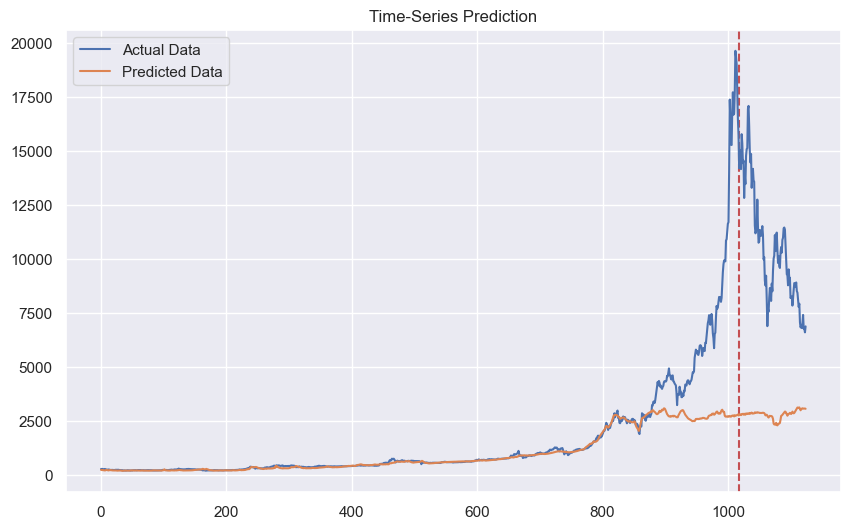

In [721]:
df_X_ss = ss.transform(df.drop(columns=['Close'])) # old transformers
df_y_mm = mm.transform(df.Close.values.reshape(-1, 1)) # old transformers
# split the sequence
df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, 100, 50)
# converting to tensors
df_X_ss = (torch.Tensor(df_X_ss))
df_y_mm = (torch.Tensor(df_y_mm))
# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 100, df_X_ss.shape[2]))

train_predict = lstm(df_X_ss) # forward pass
data_predict = train_predict.data.numpy() # numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) # reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=train_size, c='r', linestyle='--') # size of the training set

plt.plot(true, label='Actual Data') # actual plot
plt.plot(preds, label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.savefig("whole_plot.png", dpi=300)
plt.show()

In [ ]:
# salvando o modelo
torch.save(lstm.state_dict(), 'model.pth')